In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler


# **EQUATION  DEFINITION**

This section defines the mathematical model for the Duffing Oscillator in a state-space formulation, which is a classic non-linear, damped, and driven oscillator that exhibits chaotic behavior. The system is converted from a second-order ODE to two first-order ODEs, where the state is defined by position ($x$) and velocity ($v$).The function duffing_oscillator implements the following:

$\frac{dv}{dt} = -\delta v - \alpha x - \beta x^3 + \gamma_{force} \cos(\omega t)$

where:
- $\delta$: Damping coefficient (controls energy dissipation).
- $\alpha$: Linear stiffness (restoring force for small displacements).
- $\beta$: Non-linear stiffness (introduces non-linearity, crucial for chaos).
- $\gamma_{force}$: Forcing amplitude (strength of the external periodic drive).
- $\omega$: Forcing frequency (frequency of the external drive).




In [2]:
def duffing_oscillator(state, t, delta, alpha, beta, gamma_force, omega):
    x, v = state
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma_force * np.cos(omega * t)
    return [dxdt, dvdt]

# **DATA GENERATION**

This section establishes the specific parameters for the Duffing system and generates the time series data necessary for training the model. 

The time parameters are defined: a small time step (dt = 0.05) and a long time duration (t_max = 400) to capture the long-term, complex dynamics of the attractor.The odeint function is used to numerically integrate the duffing_oscillator function, solving for the position ($x$) and velocity ($v$) time series.




In [3]:
# Parámetros físicos
delta = 0.3; alpha = -1.0; beta = 1.0; gamma_force = 0.50; omega = 1.2
dt = 0.05 
t_max = 400 
t = np.arange(0, t_max, dt)
initial_state = [0.1, 0.1]
data = odeint(duffing_oscillator, initial_state, t, args=(delta, alpha, beta, gamma_force, omega))

# **MODEL TRAINING**

The goal of this section is to prepare the time series data and train a machine learning model to predict the next state of the system.
- Delay Embedding: The time series is transformed using the create_delay_embedding function with a delay ($\tau$) of 3. This technique, based on the Takens theorem, reconstructs the system's full phase space from a single time series by creating input vectors ($X$) consisting of past states $(x(t), v(t), x(t-\tau), v(t-\tau), \dots)$ to predict the next state ($Y$).
- Preprocessing: The data is split into a training set (TRAIN_SIZE = 6000) and scaled using StandardScaler. Scaling is critical for SVR performance.
- Model Selection and Training: A Support Vector Regressor (SVR) is chosen as the base estimator with specific hyperparameters (C=1000, epsilon=0.001). Since the model must predict two outputs (position $x$ and velocity $v$), a MultiOutputRegressor wrapper is used to train a separate SVR for each output dimension. The final model is then fitted to the scaled training data.


In [4]:
def create_delay_embedding(data, delay=3):
    X, Y = [], []
    for i in range(len(data) - delay):
        history = data[i:i + delay].flatten()
        X.append(history)
        Y.append(data[i + delay])
    return np.array(X), np.array(Y)

DELAY = 3
X, y = create_delay_embedding(data, delay=DELAY)
TRAIN_SIZE = 6000 
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
scaler_X = StandardScaler(); scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Entrenamiento del modelo
svr = SVR(kernel='rbf', C=1000, gamma='scale', epsilon=0.001)
model = MultiOutputRegressor(svr)
model.fit(X_train_scaled, y_train_scaled)

,estimator,"SVR(C=1000, epsilon=0.001)"
,n_jobs,None
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1000
,epsilon,0.001
,shrinking,True
,cache_size,200


# **SIMULATION**

This section tests the model's ability to perform long-term autonomous prediction by generating a time series solely from the trained SVR model.

- Recursive Time-Stepping: The simulation proceeds iteratively for a fixed number of steps (SIMULATION_STEPS_IA = 20000).
- In each step, the model predicts the next state $(x_{t+1}, v_{t+1})$ based on the current input window.
- Autonomous Update: The predicted state is immediately used to update the input window for the next prediction by discarding the oldest data points and appending the new prediction. This is crucial for evaluating the model's capacity to maintain the system's chaotic dynamics without continuous external correction.
- Inverse Scaling: The final predictions are inverse-transformed to revert the values to their original physical scale for meaningful analysis and plotting.

In [5]:
predictions_scaled = []
SIMULATION_STEPS_IA = 20000 
current_input = X_train[-1].reshape(1, -1)

for i in range(SIMULATION_STEPS_IA):
    pred = model.predict(current_input)
    predictions_scaled.append(pred[0])
    
    new_input = np.roll(current_input[0], -2)
    new_input[-2:] = pred[0]
    current_input = new_input.reshape(1, -1)

predictions = scaler_y.inverse_transform(np.array(predictions_scaled))

# **MODEL RESULTS**

This final section provides a visual comparison between the true chaotic data (simulated by odeint) and the autonomous long-term prediction from the SVR model.

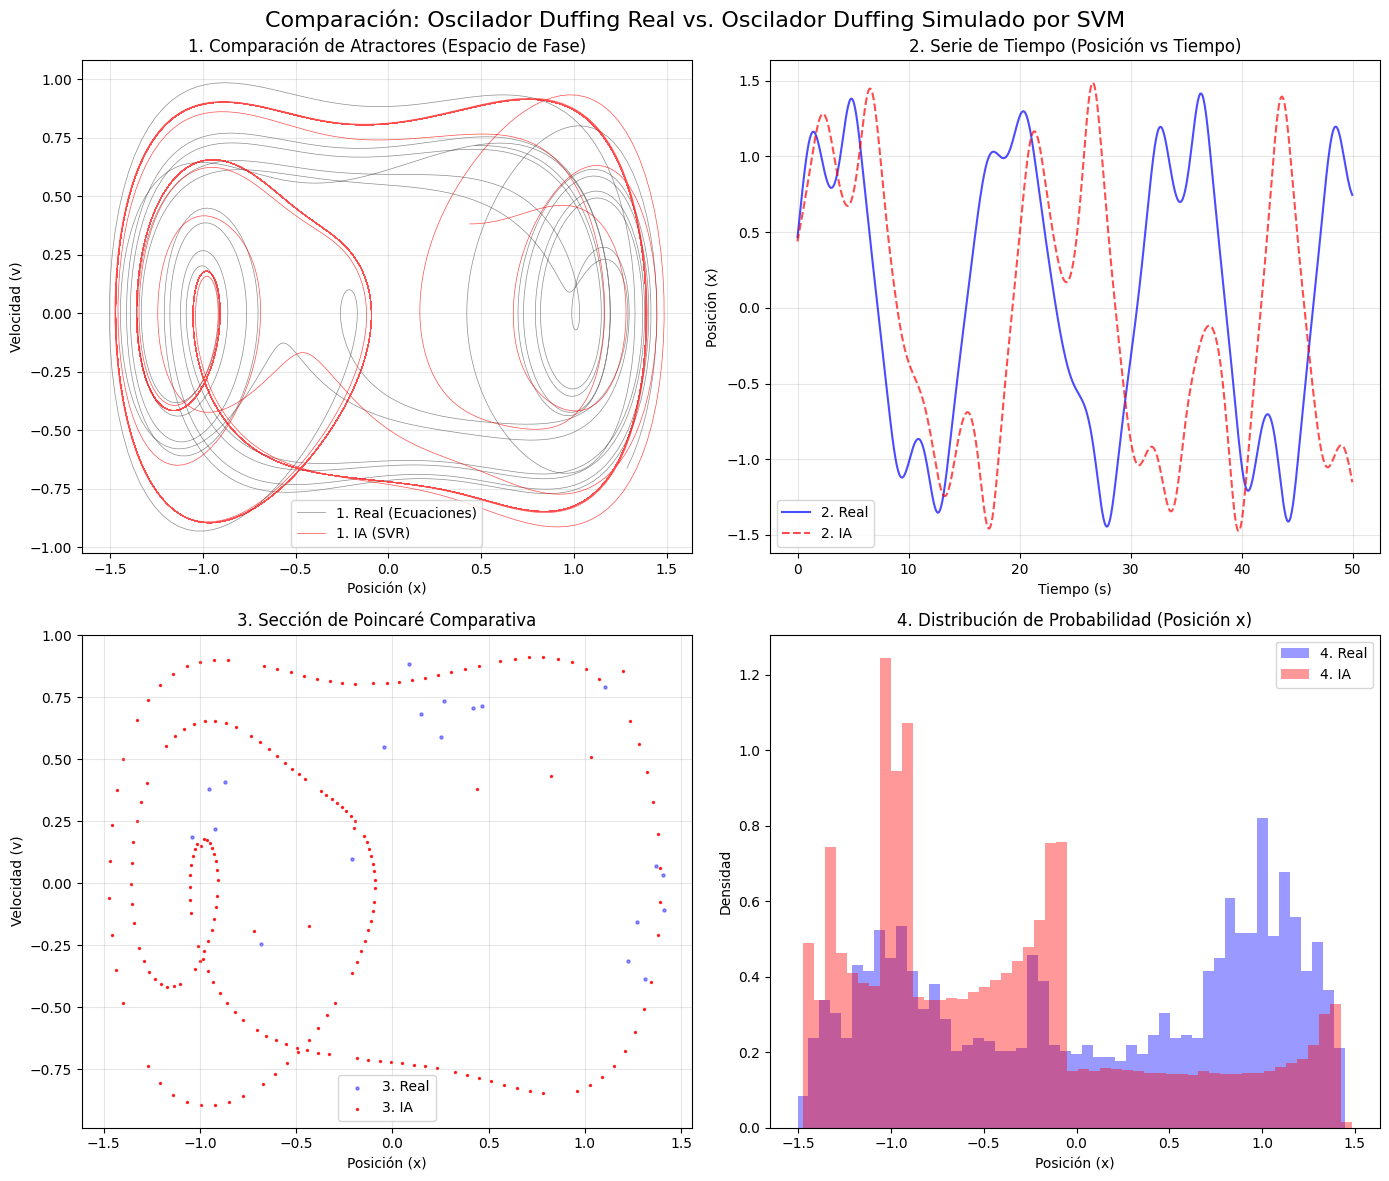

In [6]:

period = 2 * np.pi / omega
steps_per_period = int(period / dt)

# Datos de Simulación (IA)
poincare_map_ia = predictions[::steps_per_period]

# Datos Reales para comparación
data_sim_real = data[TRAIN_SIZE : TRAIN_SIZE + SIMULATION_STEPS_IA]
poincare_map_real = data_sim_real[::steps_per_period] 

plt.figure(figsize=(14, 12))

# A) ESPACIO DE FASE
plt.subplot(2, 2, 1)
# Atractor Real (Gris de fondo)
plt.plot(data_sim_real[:, 0], data_sim_real[:, 1], lw=0.5, color='gray', alpha=0.9, label='1. Real (Ecuaciones)')
# Atractor IA (Línea roja superpuesta)
plt.plot(predictions[:, 0], predictions[:, 1], lw=0.5, color='red', alpha=0.7, label='1. IA (SVR)')
plt.title("1. Comparación de Atractores (Espacio de Fase)", fontsize=12)
plt.xlabel("Posición (x)"); plt.ylabel("Velocidad (v)")
plt.legend()
plt.grid(True, alpha=0.3)

# B) SERIE DE TIEMPO
plt.subplot(2, 2, 2)
plot_steps = 1000
time_axis = np.arange(0, plot_steps * dt, dt)
# Real
plt.plot(time_axis, data_sim_real[:plot_steps, 0], color='blue', lw=1.5, alpha=0.7, label='2. Real')
# IA
plt.plot(time_axis, predictions[:plot_steps, 0], color='red', lw=1.5, alpha=0.7, linestyle='--', label='2. IA')
plt.title("2. Serie de Tiempo (Posición vs Tiempo)", fontsize=12)
plt.xlabel("Tiempo (s)"); plt.ylabel("Posición (x)")
plt.legend()
plt.grid(True, alpha=0.3)

# C) MAPA DE POINCARÉ
plt.subplot(2, 2, 3)
# Real (Azul)
plt.scatter(poincare_map_real[:, 0], poincare_map_real[:, 1], s=5, c='blue', alpha=0.4, label='3. Real')
# IA (Rojo)
plt.scatter(poincare_map_ia[:, 0], poincare_map_ia[:, 1], s=2, c='red', alpha=0.8, label='3. IA')
plt.title("3. Sección de Poincaré Comparativa", fontsize=12)
plt.xlabel("Posición (x)"); plt.ylabel("Velocidad (v)")
plt.legend()
plt.grid(True, alpha=0.3)

# D) DISTRIBUCIÓN
plt.subplot(2, 2, 4)
# Real (Azul)
plt.hist(data_sim_real[:, 0], bins=50, color='blue', alpha=0.4, density=True, label='4. Real')
# IA (Rojo)
plt.hist(predictions[:, 0], bins=50, color='red', alpha=0.4, density=True, label='4. IA')
plt.title("4. Distribución de Probabilidad (Posición x)", fontsize=12)
plt.xlabel("Posición (x)"); plt.ylabel("Densidad")
plt.legend()

plt.suptitle("Comparación: Oscilador Duffing Real vs. Oscilador Duffing Simulado por SVM", fontsize=16)
plt.tight_layout()
plt.show()